In [104]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


## Problème 1.A

Q1

In [43]:
a=10
sigma1=3
sigma2=3
def pi(x, y): 
    return  np.exp((-x**2/a**2) - y**2 - 0.25*((x**2/a**2) - y**2)**2)


In [44]:
def sample_p1(z, sigma):
    x, y = z
    x_new =  np.random.normal(x, sigma)
    alpha = min(1, pi(x_new,y)/pi(x, y))
    if np.random.rand() < alpha:
        return x_new, y
    return x, y

def sample_p2(z, sigma):
    x, y = z
    y_new =  np.random.normal(y, sigma)
    alpha = min(1, pi(x, y_new)/pi(x, y))
    if np.random.rand() < alpha:
        
        return x, y_new
    return x, y


def sample_chain(num_samples, sigma1, sigma2):
    """Sample a Markov chain using kernel P."""
    samples = []
    accepted=0
    z = (0, 0)  # Initialize at (0, 0)
    for _ in range(num_samples):
        if np.random.rand() < 0.5:
            new  = sample_p1(z, sigma1)  # Update x
            if new!=z:
                accepted+=1
            z = new
            
        else:
            new = sample_p2(z, sigma2)  # Update y
            if new!=z:
                accepted+=1
            z = new
        samples.append(z)
    return np.array(samples), accepted/num_samples

Q2

C:\Users\grego\AppData\Local\Temp\ipykernel_22784\2911755222.py:9: UserWarning: The following kwargs were not used by contour: 'level', 'label'
  plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')


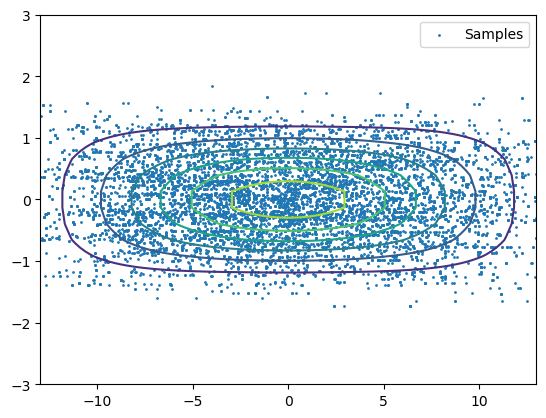

the acceptance rate is: 0.5548


In [45]:
samples, accepted = sample_chain(10000, sigma1, sigma2)
plt.scatter(samples[:, 0], samples[:, 1], s=1, label='Samples')
X=np.linspace(-13,13,100)
Y=np.linspace(-13,13,100)
Z=np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z[i,j]=pi(X[i],Y[j])
plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')
plt.xlim(-13, 13)
plt.ylim(-3, 3)
plt.legend()
plt.show()
print('the acceptance rate is:', accepted)

Q3

La distribution objective est bien approximée par l'algorithme. Néanmoins, comme on se déplace de manière orthogonale, on a des points alignés sur des lignes. Un sampling sans direction préférentielle éliminerait cela. Nous pourrions : 

- N'accepter un nouveu point qu'après avoir changé les deux dimensions
- Le ration d'acceptance est un peu élevé, on pourrait modifier les valeurs des $\sigma_i$ pour le diminuer. 

## Problème 1.B

In [46]:
1/50**2

0.0004

C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:15: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[0]/visited[0] > 0.234:
C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:19: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[1]/visited[1] > 0.234:
C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:51: UserWarning: The following kwargs were not used by contour: 'level', 'label'
  plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')


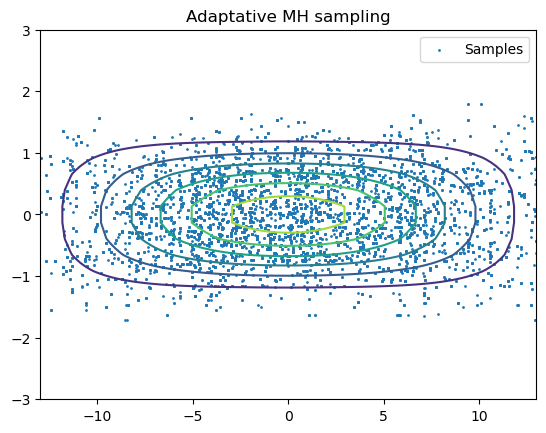

In [47]:

def sample_chain_adaptative(num_samples):
    samples = []
    accepted=np.zeros(2)
    visited=np.zeros(2)
    z = (0, 0)  # Initialize at (0, 0)
    l=np.array([np.log(30), np.log(3)])
    j=0
    sigma1=np.exp(l[0])
    sigma2=np.exp(l[1])
    for iter in range(num_samples):
        if iter%50==0 : 
            j+=1
            delta = min(0.01, 1/j**2)
            # delta=0.01
            if accepted[0]/visited[0] > 0.234:
                l[0]+=delta
            else:
                l[0]-=delta
            if accepted[1]/visited[1] > 0.234:
                l[1]+=delta
            else:
                l[1]-=delta
            sigma1=np.exp(l[0])
            sigma2=np.exp(l[1])
            visited=np.zeros(2)
            accepted=np.zeros(2)          
        if np.random.rand() < 0.5:
            visited[0]+=1
            new  = sample_p1(z, sigma1)  # Update x
            if new!=z:
                accepted[0]+=1
            z = new
            
        else:
            new = sample_p2(z, sigma2)  # Update y
            visited[1]+=1
            if new!=z:
                accepted[1]+=1
            z = new
        samples.append(z)
    return np.array(samples)

samples_adaptative = sample_chain_adaptative(10000)
plt.scatter(samples_adaptative[:, 0], samples_adaptative[:, 1], s=1, label='Samples')
X=np.linspace(-13,13,100)
Y=np.linspace(-13,13,100)
Z=np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z[i,j]=pi(X[i],Y[j])
plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')
plt.xlim(-13, 13)
plt.ylim(-3, 3)
plt.legend()
plt.title('Adaptative MH sampling')
plt.show()

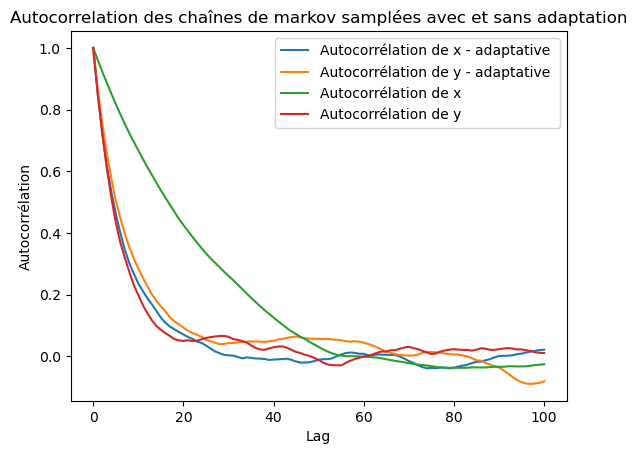

In [48]:
acf_x = acf(samples_adaptative[:, 0], nlags=100)
acf_y = acf(samples_adaptative[:, 1], nlags=100)
plt.plot(acf_x, label='Autocorrélation de x - adaptative')
plt.plot(acf_y, label='Autocorrélation de y - adaptative ')
acf_x = acf(samples[:, 0], nlags=100)
acf_y = acf(samples[:, 1], nlags=100)
plt.plot(acf_x, label='Autocorrélation de x')
plt.plot(acf_y, label='Autocorrélation de y')
plt.legend()
plt.title('Autocorrelation des chaînes de markov samplées avec et sans adaptation')
plt.xlabel('Lag')
plt.ylabel('Autocorrélation')
plt.show()

On observe que l'algorithme adaptatif permet d'avoir une autocorrélation de x bien meilleure, car elle décroit vers zéro. En effet, on vise à approximer un processus indépendant, donc on ne veut pas que les tirages soient corrélés les uns avec les autres. 

Q2

In [117]:
def f_b(x, B): 
    t1=(-(x[0]**2)/20)
    t2=-0.5*(x[1] + B*(x[0]**2) - 100*B)**2
    t3=-0.5*np.sum((x**2)[2:])
    return np.exp(t1+t2+t3)

In [69]:
# pour pouvoir tester notre nouvelle fonction sur pi 
def pi_bis(z):
    x, y = z 
    return  np.exp((-x**2/a**2) - y**2 - 0.25*((x**2/a**2) - y**2)**2)

In [50]:
def sample_one_component(x, i, function_to_sample, sigma): 
    x_new = x.copy()
    x_new[i] = np.random.normal(x[i], sigma)
    alpha = min(1, function_to_sample(x_new)/function_to_sample(x))
    if np.random.rand() < alpha:
        return x_new
    return x

In [134]:
# nouvelle fonction pour pouvoir changer de dimension
def sample_chain_adaptative_multi_gibbs(num_samples, d, function_to_sample):
    samples = []
    accepted=np.zeros(d)
    visited=np.zeros(d)
    z = np.zeros(d)  # Initialize at (0, 0)
    l=np.zeros(d)
    # if d ==2 : # pi a besoin d'une initialisation intelligente 
    #     l=np.array([np.log(30), np.log(3)])
    if d ==20 : 
        l=np.log(30)*np.ones(d) 
    j=0
    sigmas=np.exp(l)
    for iter in range(num_samples):
        if iter%50==0 : 
            j+=1
            delta = min(0.01, 1/j**2)
            # delta=0.01
            for k in range(d): 
                if accepted[k]/visited[k] > 0.234:
                    l[k]+=delta
                else:
                    l[k]-=delta
            sigmas=np.exp(l)
            visited=np.zeros(d)
            accepted=np.zeros(d)
        i = np.random.randint(d)
        visited[i]+=1
        new  = sample_one_component(z, i, function_to_sample, sigmas[i])
        if np.any(new!=z):
            accepted[i]+=1
        z = new
        samples.append(z)
    return np.array(samples)

samples_adaptative = sample_chain_adaptative(10000)


C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:15: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[0]/visited[0] > 0.234:
C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:19: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[1]/visited[1] > 0.234:


In [95]:
# nouvelle fonction pour pouvoir changer de dimension
def sample_chain_adaptative_multi_normal(num_samples, d, function_to_sample):
    samples = []
    accepted=np.zeros(d)
    visited=np.zeros(d)
    z = np.zeros(d)  # Initialize at (0, 0)
    l=np.zeros(d)
    if d ==2 : # pi a besoin d'une initialisation intelligente 
        l=np.array([np.log(30), np.log(3)])
    if d ==20 : 
        l=np.log(30)*np.ones(d) 
    sigmas=np.exp(l)
    for _ in range(num_samples):
        i = np.random.randint(d)
        visited[i]+=1
        new  = sample_one_component(z, i, function_to_sample, sigmas[i])
        if np.any(new!=z):
            accepted[i]+=1
        z = new
        samples.append(z)
    return np.array(samples)

samples_adaptative = sample_chain_adaptative(10000)


C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:15: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[0]/visited[0] > 0.234:
C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1316950341.py:19: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[1]/visited[1] > 0.234:


C:\Users\grego\AppData\Local\Temp\ipykernel_22784\1400366356.py:18: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[k]/visited[k] > 0.234:
C:\Users\grego\AppData\Local\Temp\ipykernel_22784\73527244.py:10: UserWarning: The following kwargs were not used by contour: 'level', 'label'
  plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')


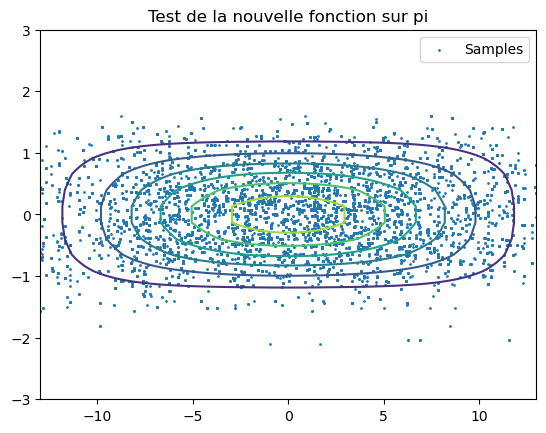

In [ ]:
samples = sample_chain_adaptative_multi_gibbs(10000, 2, pi_bis)

plt.scatter(samples[:, 0], samples[:, 1], s=1, label='Samples')
X=np.linspace(-13,13,100)
Y=np.linspace(-13,13,100)
Z=np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z[i,j]=pi(X[i],Y[j])
plt.contour(X, Y, Z.T, level=5, cmap='viridis', label='Target distribution')
plt.xlim(-13, 13)
plt.ylim(-3, 3)
plt.legend()
plt.title('Test de la nouvelle fonction sur pi')
plt.show()


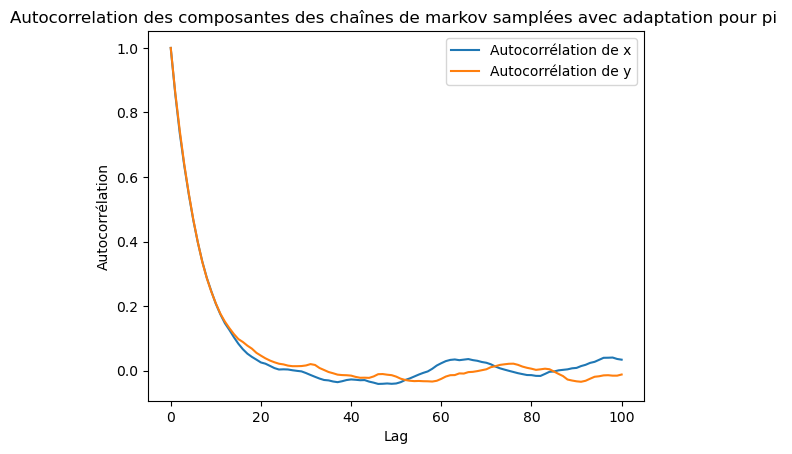

In [76]:

acf_x = acf(samples[:, 0], nlags=100)
acf_y = acf(samples[:, 1], nlags=100)
plt.plot(acf_x, label='Autocorrélation de x')
plt.plot(acf_y, label='Autocorrélation de y')
plt.legend()
plt.title('Autocorrelation des composantes des chaînes de markov samplées avec adaptation pour pi ')
plt.xlabel('Lag')
plt.ylabel('Autocorrélation')
plt.show()

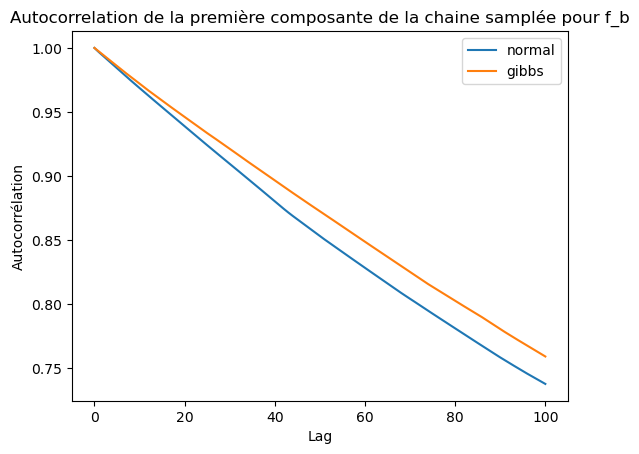

In [121]:
samples = sample_chain_adaptative_multi_normal(100000, 20, lambda x: f_b(x, 0.01))
samples_gibbs=sample_chain_adaptative_multi_gibbs(100000, 20, lambda x: f_b(x, 0.01))
acfs=[]
acfs_gibbs=[]
for i in range(20): 
    acfs.append(acf(samples[:, i], nlags=100))
    acfs_gibbs.append(acf(samples_gibbs[:, i], nlags=100))

acfs=np.array(acfs[1])
acfs_gibbs=np.array(acfs_gibbs[1])
plt.plot(acfs, label='normal')
plt.plot(acfs_gibbs, label='gibbs')
plt.legend()
plt.title('Autocorrelation de la première composante de la chaine samplée pour f_b')
plt.xlabel('Lag')
plt.ylabel('Autocorrélation')
# plt.yscale('log')
plt.show()

On observe encore une fois que le gibbs sampler surpasse le normal. Néanmoins, sur ce problème de grande dimension, la convergence est plus lente. 

## Problem 2.A

In [ ]:


mu = np.array([ [2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],[3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
    [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],[4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])
sigma = 0.1
weights = np.ones(20) / 20

def target_density(x):
    densities = [w * (1 / (2 * np.pi * sigma**2)) * np.exp(-0.5 * np.sum((x - m)**2) / sigma**2) for w, m in zip(weights, mu)]
    return sum(densities)


In [135]:
def metropolis_hastings(target_density, num_samples, sigma_prop):
    samples = []
    current = np.array([0.0, 0.0])  
    for _ in range(num_samples):
        proposal = current + np.random.normal(scale=sigma_prop, size=2)
        acceptance_ratio = target_density(proposal) / target_density(current)
        if np.random.rand() < acceptance_ratio:
            current = proposal
        samples.append(current)
    return np.array(samples)

num_samples = 10000
sigma_prop = 0.5  
samples = metropolis_hastings(target_density, num_samples, sigma_prop)
sample_gibbs=sample_chain_adaptative_multi_gibbs(10000, 2, target_density)

C:\Users\grego\AppData\Local\Temp\ipykernel_22784\3215022195.py:20: RuntimeWarning: invalid value encountered in scalar divide
  if accepted[k]/visited[k] > 0.234:


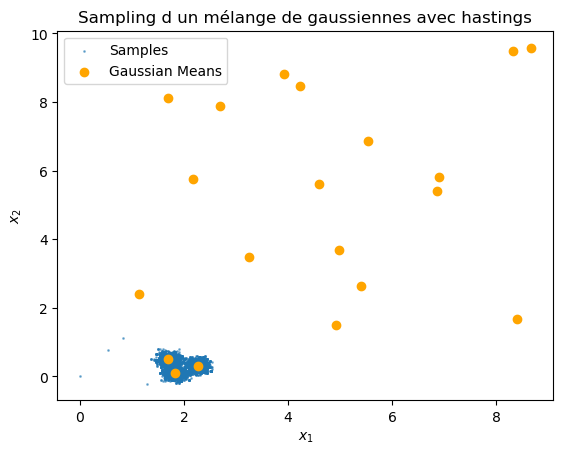

In [138]:
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, label='Samples')

plt.scatter(mu[:, 0], mu[:, 1], color='orange', label='Gaussian Means')

plt.title('Sampling d un mélange de gaussiennes avec hastings')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()


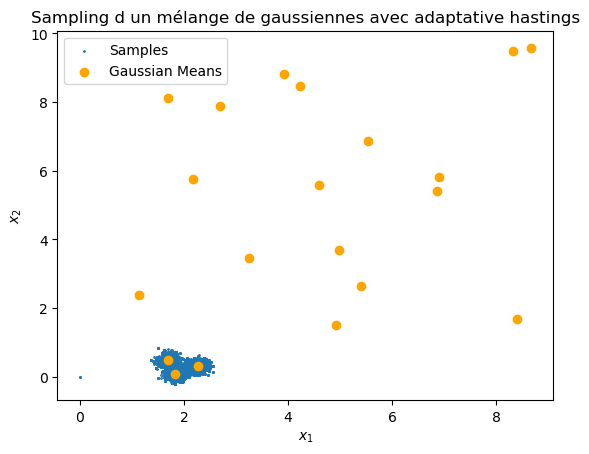

In [ ]:
plt.scatter(sample_gibbs[:, 0], sample_gibbs[:, 1], s=1, label='Samples')
plt.scatter(mu[:, 0], mu[:, 1], color='orange', label='Gaussian Means')
plt.title('Sampling d un mélange de gaussiennes avec adaptative hastings')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

En effet, ces deux modèles restent bloqués dans une zone du support. 

## 2.B

In [238]:
def distrib_puissance_T(distrib, T): 
    return lambda x: distrib(x)**(1/T)

In [241]:
def metropolis_hastings_bis(target_density, num_samples, cov_matric_prop, d):
    samples = []
    current = np.zeros(d)
    for _ in range(num_samples):
        proposal = current + np.random.multivariate_normal(mean=np.zeros(d), cov=cov_matric_prop)
        acceptance_ratio = target_density(proposal) / target_density(current)
        if np.random.rand() < acceptance_ratio:
            current = proposal
        samples.append(current)
    return np.array(samples)

In [246]:
# paralell tempering
def parallel_tempering(target_density, num_samples, num_chains, d, temperatures, covariances) : 
    chains = np.zeros((num_chains, num_samples, d))
    for i in range(num_chains): 
        chains[i, 0] = np.zeros(d) # initialisation des chaines
    for i in range(num_samples): 
        for j in range(num_chains): 
            chains[j, i] = metropolis_hastings_bis(distrib_puissance_T(target_density, temperatures[j]), 1, covariances[j], d)
        # Choose uniformly (i, j) ∈ J1,KK2, with |i − j| = 1 ;
        c2=num_chains
        while c2 >=num_chains:
            c1 = np.random.randint(num_chains - 1)
            c2 = c1 + 1
        alpha = (distrib_puissance_T(target_density, temperatures[c1])(chains[c2, i]) * distrib_puissance_T(target_density, temperatures[c2])(chains[c1, i])) / (distrib_puissance_T(target_density, temperatures[c1])(chains[c1, i]) * distrib_puissance_T(target_density, temperatures[c2])(chains[c2, i]))
        alpha = min(1, alpha)
        if np.random.rand() < alpha:
            chains[c1, i], chains[c2, i] = chains[c2, i], chains[c1, i]
    return chains
        

In [250]:
temps= [60, 21.6, 7.7, 2.8, 1 ]
covariances = [0.25**2 * temps[i]*np.eye(2) for i in range(5)] 
samples = parallel_tempering(pi_bis, 100, len(temps),     2, temps, covariances)